# Setup notebook

In [1]:
%gui qt
%matplotlib notebook

import sys
import os
import time
import logging
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

In [2]:
import qcodes as qc
import broadbean as bb

from broadbean.plotting import plotter

In [3]:
from qcodes import load_by_id
from qcodes import validators
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
# from qcodes.sweep import sweep, nest, chain, szip, getter, setter
# from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter

In [4]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.qctools import measurement; reload(measurement)
from pytopo.qctools.measurement import MeasurementExt

from pytopo.mplplots import init_nb_plotting; reload(init_nb_plotting)
from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots
from pytopo.mplplots import tools as mpltools

from pytopo.qctools.dataset2 import select_experiment

import plottr; reload(plottr)
from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber
from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

from pytopo.rf import alazar_detector; reload(alazar_detector)
from pytopo.rf.alazar_detector import AlazarDetector

from cqed import broadbean; reload(broadbean)
from cqed.broadbean import BroadBeanSequence, BluePrints

from cqed import bb_sequences; reload(bb_sequences)
from cqed.bb_sequences import TriggeredReadoutSequence
from cqed.bb_sequences import AWGGateRamp1D

In [5]:
from pytopo.qctools import hard_sweep; reload(hard_sweep)
from pytopo.qctools.hard_sweep import HardSweep, HardSweepDetector

# Initialize

## Global settings

In [6]:
SAMPLE = 'Cq334'

qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20181011.db"

BroadBeanSequence.chan_map = {
    1 : ['awg_voltage', 'ro_trigger', None],
}
BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0
BroadBeanSequence.chan_settings[2]['Vpp'] = 2.0

BroadBeanSequence.sweep_wait = None





TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', None],
}

qc.dataset.database.initialise_database()

## Classes

### AWG

In [ ]:
# ramp = bb.PulseAtoms.ramp

# class BluePrints(object):
    
#     def __init__(self, chan_map, sample_rate=1e9):
#         self.bps = {}
#         self.map = {}
        
#         for i, lst in chan_map.items():
#             self.bps[i] = bb.BluePrint()
#             self.bps[i].setSR(sample_rate)
#             for j, name in enumerate(lst):
#                 if name is not None:
#                     self.map[name] = (i, j)
                    
#     def __getitem__(self, name):
#         if self.map[name][1] == 0:
#             return self.bps[self.map[name][0]]
#         else:
#             return getattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]))
        
#     def __setitem__(self, name, value):
#         if self.map[name][1] == 0:
#             self.bps[self.map[name][0]] = value
#         else:
#             setattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]), value)
        
#     def __call__(self):
#         return list(self.bps.items())
    

# class BroadBeanSequence(HardSweep):
    
#     chan_map = {}
    
#     def __init__(self, name, awg, chan_map, **kw):
#         self.awg = awg
#         self.chan_map = chan_map
        
#         super().__init__(name, **kw)
        
#         self.add_parameter('sample_rate', get_cmd=None, set_cmd=None, 
#                            unit='GS/s', initial_value=1e9)
        
#     def sequence(self):
#         raise NotImplementedError
        
        
#     def setup(self, program_awg=True, start_awg=True):
#         super().setup()
        
#         self.awg.stop()
        
#         if program_awg:
#             self.awg.clock_freq(self.sample_rate())
#             seq = self.sequence()
#             pkg = seq.outputForAWGFile()
#             self.awg.make_send_and_load_awg_file(*pkg[:])
        
#             for ch_no, ch_desc in self.chan_map.items():
#                 self.awg.set('ch{}_state'.format(ch_no), 1)

#         if start_awg:
#             self.awg.start()

        
# class AWGGateRamp1D(BroadBeanSequence):
    
#     trigger_delay = 100e-9
#     alazar_trigger_len = 100e-9
    
#     def __init__(self, *arg, **kw):
        
#         kw['sweep_dims'] = ['voltage_vals', ]
        
#         super().__init__(*arg, **kw)
        
#         self.add_parameter('step_len', set_cmd=None, 
#                            unit='s', initial_value=10e-6)
#         self.add_parameter('start_voltage', set_cmd=None,
#                            unit='V', initial_value=0)
#         self.add_parameter('stop_voltage', set_cmd=None,
#                            unit='V', initial_value=1)
#         self.add_parameter('voltage_points', set_cmd=None,
#                            unit='', initial_value=11)
#         self.add_parameter('ramp_down_time', set_cmd=None,
#                            unit='s', initial_value=10e-6)
        
#     def setup(self, **kw):
#         vpts = np.linspace(self.start_voltage(), self.stop_voltage(), self.voltage_points())
#         self.voltage_vals(vpts)
#         super().setup(**kw)
        
        
#     def sequence(self):
#         elem = bb.Element()
#         bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
#         cut_t = 0
# #         bps['awg_voltage'] = []
#         bps['alz_mrkr'] = []
#         for i, v in enumerate(self.voltage_vals()):
#             bps['awg_voltage'].insertSegment(i, ramp, (v, v), 
#                                              dur=self.step_len(), name='voltage')
#             bps['alz_mrkr'].append((self.step_len() * i + self.trigger_delay, self.alazar_trigger_len))
            
#         bps['awg_voltage'].insertSegment(-1, ramp, (v, self.start_voltage()), 
#                                          dur=self.ramp_down_time(), name='voltage')        
            
        
#         for n, bp in bps():
#             elem.addBluePrint(n, bp)
            
#         seq = bb.Sequence()
#         seq.name = 'v_ramp'
#         seq.addElement(1, elem)
#         seq.setSR(self.sample_rate())
        
#         seq.setChannelAmplitude(1, 1)
#         seq.setChannelOffset(1, 0)
#         seq.setChannelAmplitude(2, 1)
#         seq.setChannelOffset(2, 0)

#         seq.setSequencingTriggerWait(1, 0)
#         seq.setSequencingGoto(1, 1)
        
#         return seq
        
        
# class SimpleAWGSpec(BroadBeanSequence):

#     def __init__(self, *arg, **kw):
        
#         kw['sweep_dims'] = ['awg_sweep_idx', ]
        
#         super().__init__(*arg, **kw)
        
#         self.add_parameter('initial_delay', set_cmd=None,
#                            unit='s', initial_value=1e-6)
#         self.add_parameter('alazar_trigger_len', set_cmd=None,
#                            unit='s', initial_value=1e-7)
#         self.add_parameter('alazar_trigger_delay', set_cmd=None, 
#                            unit='s', initial_value=1e-6)
#         self.add_parameter('seq_len', set_cmd=None, 
#                            unit='s', initial_value=1e-5)
#         self.add_parameter('final_delay', set_cmd=None,
#                            unit='s', initial_value=1e-6)

#     def setup(self, **kw):
#         self.awg_sweep_idx([1,])
#         super().setup(**kw)
        
#     def sequence(self):
#         elem = bb.Element()
        
#         bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
#         bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
#         bps['alz_mrkr'] = [(self.initial_delay(), self.alazar_trigger_len())]
# #         bps['ro_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
# #                            self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
# #         bps['test'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
# #         bps['q_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
# #                           self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
        
#         for n, bp in bps():
#             elem.addBluePrint(n, bp)
            
#         seq = bb.Sequence()
#         seq.name = 'spec'
#         seq.addElement(1, elem)
#         seq.setSR(self.sample_rate())
        
#         seq.setChannelAmplitude(1, 1)
#         seq.setChannelOffset(1, 0)
#         seq.setChannelAmplitude(2, 1)
#         seq.setChannelOffset(2, 0)

#         seq.setSequencingTriggerWait(1, 0)
#         seq.setSequencingGoto(1, 1)
        
#         return seq

## Create instruments

### Physical instruments

In [7]:
inst_list = []

from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, "ivvi", "ASRL5::INSTR")
inst_list.append(ivvi)

for i in range(1,16):
    ivvi.parameters['dac{}'.format(i)].set_step(2)
    ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

ivvi.dac4.set_delay(0.001)
ivvi.dac4.set_step(20)

ivvi.dac7.set_delay(0.001)
ivvi.dac7.set_step(20)


from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = create_inst(Keysight_34465A, "key1", "TCPIP::169.254.4.62::INSTR", force_new_instance=True)
key2 = create_inst(Keysight_34465A, "key2", "TCPIP::169.254.4.61::INSTR", force_new_instance=True)
inst_list.append(key1)
inst_list.append(key2)

from qcodes.instrument_drivers.stanford_research.SR860 import SR860
lockin1 = create_inst(SR860, "lockin1", "GPIB0::3::INSTR")
inst_list.append(lockin1)

from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg = instools.create_inst(Tektronix_AWG5014, 'awg', address="TCPIP0::169.254.183.196::inst0::INSTR")
inst_list.append(awg)

from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430,AMI430_3D
ami_x = create_inst(AMI430, "AMI430_x", "169.254.89.110", port = 7180, has_current_rating=True)
ami_y = create_inst(AMI430, "AMI430_y", "169.254.116.158", port = 7180, has_current_rating=True)
ami_z = create_inst(AMI430, "AMI430_z", "169.254.67.133", port = 7180, has_current_rating=True)

ami = create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)
inst_list.append(ami)


from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgBufCtl, AvgDemodCtl, AvgIQCtl
# from pytopo.rf.alazar_acquisition import DemodAcqCtl, IQAcqCtl, DemodRelAcqCtl, IQRelAcqCtl

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

avg_acq = instools.create_inst(AvgBufCtl, 'avg_acq', 'alazar', force_new_instance=True)
inst_list.append(avg_acq)

avgdemod_acq = instools.create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
inst_list.append(avgdemod_acq)

avgiq_acq = instools.create_inst(AvgIQCtl, 'avgiq_acq', 'alazar', force_new_instance=True)
inst_list.append(avgiq_acq)

# demod_acq = instools.create_inst(DemodAcqCtl, 'demod_acq', 'alazar', force_new_instance=True)
# inst_list.append(demod_acq)

# demodrel_acq = instools.create_inst(DemodRelAcqCtl, 'rel_acq', 'alazar', force_new_instance=True)
# inst_list.append(demodrel_acq)

# iqrel_acq = instools.create_inst(IQRelAcqCtl, 'iqrel_acq', 'alazar', force_new_instance=True)
# inst_list.append(iqrel_acq)

# iq_acq = instools.create_inst(IQAcqCtl, 'iq_acq', 'alazar', force_new_instance=True)
# inst_list.append(iq_acq)


from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.234.107")
RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.2.20")

from pytopo.rf.sources import HeterodyneSource
hetsrc = instools.create_inst(HeterodyneSource, 'hetsrc', LO=LO, RF=RF, force_new_instance=True)
inst_list.append(hetsrc)

from qcodes.instrument_drivers.Minicircuits.RUDAT_13G_90 import RUDAT_13G_90_USB
ro_attenuator = instools.create_inst(RUDAT_13G_90_USB, 'ro_attenuator')
inst_list.append(ro_attenuator)

station = qc.Station(*inst_list)

Initialized IVVI-rack in 0.07s
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.08s
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.08s


d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:578: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:590: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


Connected to: Stanford_Research_Systems SR860 (serial:003104, firmware:V1.47) in 0.10s
Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.04s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170025, firmware:2.57) in 1.05s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170026, firmware:2.57) in 0.83s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170024, firmware:2.57) in 1.07s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Mini-Circuits MN=RUDAT-13G-90 (serial:SN=11704210002, firmware:C9-2) in 0.62s


In [8]:
from qcodes.instrument_drivers.rigol.DG4000 import Rigol_DG4000
fg = instools.create_inst(Rigol_DG4000, 'fg', address="TCPIP0::169.254.190.44")

Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.06s


In [9]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
#                               put visa address here, see e.g. NI Max
#                               or look up the IP address on 
#                               the instrument itself
ls = instools.create_inst(Model_372, 'lakeshore_372', 'TCPIP::169.254.170.228::7777::SOCKET', 
                          force_new_instance=True)

Connected to: LSCI 372 (serial:LSA17VE, firmware:1.3) in 0.05s


In [10]:
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import DemodCtl

demod_acq = instools.create_inst(DemodCtl, 'demod_acq', 'alazar', force_new_instance=True)
add2station(station, demod_acq)

# demod_acq = instools.create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
# add2station(station, avgdemod_acq)

In [11]:
ivvi.dac16.set_delay(0.001)
ivvi.dac16.set_step(20)

ivvi.dac5.set_delay(0.001)
ivvi.dac5.set_step(20)

ivvi.dac7.set_delay(0.0001)
ivvi.dac7.set_step(100)

ivvi.dac6.set_delay(0.001)
ivvi.dac6.set_step(50)

d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:590: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "
d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:578: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "


### Virtual instruments

#### IVVI rack

In [12]:
from pytopo import ivvi as ivvi_ext; reload(ivvi_ext)
from pytopo.ivvi import IVVISetup

SD_current_resistance = 12e3 + 10e3 + 3.4e3
SD_dac_multiplier = 1e-2
SD_lockin_volt_multiplier = 1e-4
SD_current_gain = 1e7

ivvi_setup = create_inst(IVVISetup, 'ivvi_setup', ivvi=ivvi, force_new_instance=True)
station = add2station(station, ivvi_setup)


ivvi_setup.add_dac_voltage_src('SD', 
                               dac_number=4, 
                               multiplier=SD_dac_multiplier)

ivvi_setup.add_voltage_src('SD_lockin', 
                           param=lockin1.amplitude, 
                           multiplier=SD_lockin_volt_multiplier)

ivvi_setup.add_current_meas('SD', 
                            voltage_param=key1.volt, 
                            gain=SD_current_gain)

ivvi_setup.add_conductance_meas('SD',
                                param=lockin1.X,
                                gain=SD_current_gain,
                                r_series = 13.4e3,
                                lockin_dV = ivvi_setup.SD_lockin_voltage())
                                
ivvi_setup.add_dac_voltage_src('T1', 
                               dac_number=9, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('T2', 
                               dac_number=10, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('T3', 
                               dac_number=8, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('T4', 
                               dac_number=11, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('R2', 
                               dac_number=7, 
                               multiplier=0.001)
ivvi_setup.add_dac_voltage_src('R2_coarse', 
                               dac_number=14, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('R1', 
                               dac_number=5, 
                               multiplier=0.01)
ivvi_setup.add_dac_voltage_src('R1_coarse', 
                               dac_number=6, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('P2', 
                               dac_number=12, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('P1', 
                               dac_number=13, 
                               multiplier=1)
ivvi_setup.add_dac_voltage_src('G_fine', 
                               dac_number=16, 
                               multiplier=0.01)
ivvi_setup.add_dac_voltage_src('G_coarse', 
                               dac_number=15, 
                               multiplier=1)

ivvi_setup.SD_lockin_voltage(10e-6)

def print_IVVI_dac_list():
    for i in range(16):
        print('IVVI DAC #{} at {} mV'.format(i+1, ivvi.get('dac{}'.format(i+1))))

#### Default AWG and RF

In [13]:
# AWG_CHANS = {
# #         1 : ['awg_voltage', 'alz_mrkr', None],
#         1 : ['ro', 'alz_mrkr', None],
#     }

RF.frequency(3e8)

IF = 8e6

hetsrc.IF(IF)
hetsrc.frequency(hetsrc.frequency())


LO.power(15)
RF.power(-10)

ro_attenuator.attenuation(40)

In [ ]:
# awg_spec_sweep = create_inst(SimpleAWGSpec, 'awg_spec_sweep', awg=awg, chan_map=AWG_CHANS, force_new_instance=True)
# station = add2station(station, awg_spec_sweep)

# avg_detector = create_inst(AlazarDetector, name='avg_detector', 
#                            acqctl=avg_acq, force_new_instance=True)
# station = add2station(station, avg_detector)

# avgdemod_detector = create_inst(AlazarDetector, name='avgdemod_detector', 
#                                 acqctl=avgdemod_acq, force_new_instance=True)
# station = add2station(station, avgdemod_detector)

# avgiq_detector = create_inst(AlazarDetector, name='avgiq_detector', 
#                              acqctl=avgiq_acq, force_new_instance=True)
# station = add2station(station, avgiq_detector)

# # iq_detector = create_inst(AlazarDetector, name='iq_detector', acqctl=iq_acq, force_new_instance=True)
# # station = add2station(station, iq_detector)

In [ ]:
# awg_ramp = create_inst(AWGGateRamp1D, 'awg_ramp', awg=awg, chan_map=AWG_CHANS, force_new_instance=True)
# station = add2station(station, awg_ramp)

#### Alazar

In [14]:
### Configure ATS settings

ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
#     external_sample_rate=int(2e8),
    sample_rate=int(2e8),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)
    
    
hetsrc.frequency(500e6)
hetsrc.IF(8e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
RF.pulsemod_state('off')

ro_attenuator.attenuation(35)

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Alazar config is deprecated. Please replace with setting of paramters directly with the syncing context manager


# Experiments

In [ ]:
demod_detector = create_inst(AlazarDetector, name='demod_detector', 
                             acqctl=demod_acq, sweep_params=[], force_new_instance=True)

station = add2station(station, demod_detector)
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)

sequence.sample_rate(1e7)
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(1e-6) # short trigger for the alazar
sequence.seq_len(0.1)

setup_awg = True
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)


# set the sweeper
det = demod_detector
det.avg_buffers(False)

det.set_sweeper(sequence)
det.acq_time(sequence.seq_len() - 2e-6)
det.demod_frq(hetsrc.IF())

# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=2,
#     allocated_buffers=1,
)

det.setup()

print(det.sweep_dims, det.sweep_shape)

In [ ]:
data = det.acquisition()
tvals = demod_acq.demod_tvals
data.shape, det.sweep_shape

In [ ]:
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.plot(data[0, 0, :, 0].real)
ax.plot(data[0, 0, :, 0].imag)

ax = axes[1]
ax.plot(data[0, 0, :, 1].real)
ax.plot(data[0, 0, :, 1].imag)

In [ ]:
nperiods = 5000
newlen = data.shape[2]//nperiods*nperiods
avgdata = data[:,:,:newlen,:].reshape(2, 1,-1, nperiods, 2).mean(axis=-2)

fig, axes = plt.subplots(2, 2)

ax = axes[0,0]
ax.plot(avgdata[0, 0, :, 0].real)
ax.plot(avgdata[0, 0, :, 0].imag)

ax = axes[1,0]
ax.plot(avgdata[0, 0, :, 1].real)
ax.plot(avgdata[0, 0, :, 1].imag)

ax = axes[0,1]
ax.plot(np.angle(avgdata[0, 0, :, 1].real+1j*avgdata[0, 0, :, 1].imag))
# ax.plot()

ax = axes[1,1]
ax.plot(np.abs(avgdata[0, 0, :, 1].real+1j*avgdata[0, 0, :, 1].imag))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.415)
ivvi_setup.T4_voltage(-0.47)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)

directory = "D:/OneDrive/BF1/Data/time_traces/test/6/"
try:
    os.makedirs(directory)
except:
    pass
    
for pg in np.linspace(0e-3, 4e-3, 101):
    ivvi_setup.G_fine_voltage(pg)
    data = det.acquisition()
    np.savez(directory+"data_pg_"+str(pg*1e3)+".npz", data = data)


# meas = MeasurementExt(station, exp=exp, 
#                       hard_sweep_detector=det,
#                       soft_sweep_params=[
#                           ivvi_setup.G_fine_voltage,
#                       ])


# # the measurement loop
# meas.write_period = 2


# with meas.run() as datasaver:

# #     datasaver.dataset.subscribe(
# #         QcodesDatasetSubscriber(datasaver.dataset), 
# #         state=[], min_wait=0, min_count=1,
# #     )


#     for pg in np.linspace(0e-3, 2e-3, 2):
#         ivvi_setup.G_fine_voltage(pg)

#         det.acquisition() # this gets the data from the alazar
#         datasaver.add_result(*meas.get_result())



In [ ]:
strptime?

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.415)
ivvi_setup.T4_voltage(-0.47)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)

directory = "D:/OneDrive/BF1/Data/time_traces/test/3/"
try:
    os.makedirs(directory)
except:
    pass
    
pg = 0.73e-3
ivvi_setup.G_fine_voltage(pg)
data = det.acquisition()
np.savez(directory+"data_pg_"+str(pg*1e3)+".npz", data = data)

In [ ]:
demod_detector = create_inst(AlazarDetector, name='avgdemod_detector', 
                                acqctl=demod_acq, force_new_instance=True)
station = add2station(station, avgdemod_detector)
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(1e-3) # quick rep-rate is OK here?
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)


### Set up the detector

# set the sweeper
det = demod_detector
det.avg_buffers(False)

det.set_sweeper(sequence)
# acquisition time
det.acq_time(sequence.seq_len() - 2e-6)
# det.acq_time(100e-3)
# demod frequency
det.demod_frq(hetsrc.IF())
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=1,
)

det.setup()

print(det.sweep_dims, det.sweep_shape)

In [ ]:
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.G_fine_voltage(-3e-3)


data = det.acquisition()
data.shape, det.sweep_shape

In [ ]:
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.plot(data[0, :, 0].real)
ax.plot(data[0, :, 0].imag)

ax = axes[1]
ax.plot(data[0, :, 1].real)
ax.plot(data[0, :, 1].imag)
# ax.plot(np.abs(data[0, :, 1]))

In [ ]:
def boxcar(y, window_size=3):
    filt = np.ones(window_size) / window_size
    return np.convolve(y, filt)

In [ ]:
data_real = data[0, :, 1].real
av = boxcar(data_real,1)

fig, axes = plt.subplots(2, 1)

ax = axes[1]
ax.plot(av)

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.415)
ivvi_setup.T4_voltage(-0.47)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )


    for pg in np.linspace(0e-3, 2e-3, 21):
        ivvi_setup.G_fine_voltage(pg)

        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result())

# TQD measurements

In [ ]:
fg.ch1_output_enabled(False)
fg.ch1_frequency(500)

In [ ]:
def trigger_func(do_start):
#     print('calling trigger func with argument', do_start)
    if do_start:
#         print('start AWG')
        station.awg.start()
    else:
#         print('stop AWG')
        station.awg.stop()
    
def trigger_func_funcgen(do_start):
#     print('calling trigger func with argument', do_start)
    if do_start:
        fg.ch1_output_enabled(True)
    else:
        fg.ch1_output_enabled(False)

In [ ]:
fg.ch1_output_enabled(False)
setup_awg = True
navgs = 1

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
# acq.trigger_func = trigger_func
acq.trigger_func = trigger_func_funcgen

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
sequence.step_len(10e-6)
sequence.start_voltage(-0.01)
sequence.stop_voltage(0.0)
sequence.voltage_points(1000)
# sequence.start_voltage(0.0)
# sequence.stop_voltage(.005)
# sequence.voltage_points(100)

# sequence.sweep_wait = 'off'  # why is this not a qcodes parameter :'(
# sequence.setup(start_awg=False)

sequence.sweep_wait = 'first'  # why is this not a qcodes parameter :'(
sequence.setup(start_awg=True)

# if setup_awg:
#     sequence.setup(program_awg=True, start_awg=False) # program and start only if something else is running before
# else:
#     sequence.setup(program_awg=False, start_awg=False)
    
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
# ivvi_setup.R1_voltage(0)
# ivvi_setup.R2_voltage(0)
# ivvi_setup.P1_voltage(0)
# ivvi_setup.P2_voltage(0)

# ivvi_setup.T1_voltage(-0.25)
# ivvi_setup.T2_voltage(-0.16)
# ivvi_setup.T3_voltage(-0.33)
# ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0.2e-3)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(12.2)

hetsrc.frequency(443094846.067)


hetsrc.RF.on()
hetsrc.LO.on()

## Debugging sweep frequency

In [ ]:
fg.ch1_output_enabled(True)
fg.ch1_frequency(100)

In [ ]:
# here: set up function generator
setup_awg = True
# navgs = 50

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
acq.trigger_func = trigger_func_funcgen

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
sequence.step_len(50e-6)
sequence.start_voltage(-0.005)
sequence.stop_voltage(0.0)
sequence.voltage_points(50)

sequence.sweep_wait = 'first'  # why is this not a qcodes parameter :'(
sequence.setup(start_awg=True, program_awg=True)
    
# print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points() * 50, 
    buffers_per_acquisition=1,
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
fg.ch1_output_enabled(False)
data = detector.acquisition()
fg.ch1_output_enabled(False)

In [ ]:
data.shape

In [ ]:
data2 = data.reshape(50, 50, 2) # .mean(axis=0)

phi = np.mod(np.angle(data2[...,1])-np.angle(data2[...,0]),2*np.pi)
mag = np.abs(data2[..., 1])

fig, ax = plt.subplots(1,1)
im = ax.imshow(phi, aspect='auto')
fig.colorbar(im)

# fig, ax = plt.subplots(1,1)
# ax.plot(phi)

# fig, ax = plt.subplots(1,1)
# ax.plot(mag)

In [ ]:
data3 = data2.mean(axis=1)
phi = np.mod(np.angle(data3[...,1])-np.angle(data3[...,0]),2*np.pi)

fig, ax = plt.subplots(1,1)
ax.plot(phi)

In [ ]:
# fig, ax = plt.subplots(1,1)
# ax.imshow(np.abs(data[..., 0].reshape(-1,)).T,
#           aspect='auto')
phi = np.mod(np.angle(data[:,1])-np.angle(data[:,0]),2*np.pi)
mag = np.abs(data[..., 1])

fig, ax = plt.subplots(1,1)
ax.plot(mag, 'o-')


In [ ]:
100 * 2e8 * 100 * 2 * 1e-6

In [ ]:
np.arange(10).reshape(2,5).mean()

## Time traces

In [ ]:
setup_awg = True
navgs = 1

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
acq.trigger_func = trigger_func

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
sequence.step_len(1e-3)
sequence.start_voltage(0)
sequence.stop_voltage(0.00001)
sequence.voltage_points(100)
# sequence.start_voltage(0.0)
# sequence.stop_voltage(.005)
# sequence.voltage_points(100)
sequence.sweep_wait = 'off'  # why is this not a qcodes parameter :'(
# sequence.setup(start_awg=False)

if setup_awg:
    sequence.setup(program_awg=True, start_awg=False) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.415)
ivvi_setup.T4_voltage(-0.47)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)


exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0,-5e-3,51):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

## R1 vs R2 (hard sweep) CSD

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.16)
ivvi_setup.T3_voltage(-0.33)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0.2e-3)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(12.2)

hetsrc.frequency(443094846.067)


hetsrc.RF.on()
hetsrc.LO.on()

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.R1_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0.05, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r1 in np.linspace(0e-3,1e-3,25):
        ivvi_setup.R1_voltage(r1)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
acq.samples_per_record() / 1e8 * 1e6

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.5)
ivvi_setup.T2_voltage(-0.250)
ivvi_setup.T3_voltage(-0.3)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0.05, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0,1e-3,101):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

### Magnetic field CSD

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.05, 90, 0])

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.0, 90, 0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.5)
ivvi_setup.T2_voltage(-0.250)
ivvi_setup.T3_voltage(-0.420)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.R1_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


hetsrc.frequency(set_freq_field2(0.1, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r1 in np.linspace(0,2e-3,101):
        ivvi_setup.R1_voltage(r1)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.5)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)


ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.R1_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

for t2 in [-0.250]:
    ivvi_setup.T2_voltage(t2)
    for t3 in np.linspace(-0.4, -0.30, 11):
        ivvi_setup.T3_voltage(t3)
        
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for r1 in np.linspace(0,2e-3,51):
                ivvi_setup.R1_voltage(r1)

                cdata = detector.acquisition() # this gets the data from the alazar
                datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                #                     (detector.sweep_params[0], sequence.voltage_vals()),
                #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.35)
ivvi_setup.T4_voltage(-0.32)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.R1_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

for pg in np.linspace(0, 0.3e-3, 7):
    ivvi_setup.G_fine_voltage(pg)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r1 in np.linspace(1.2e-3,2.5e-3,51):
            ivvi_setup.R1_voltage(r1)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

## Soft sweep R1 vs R2

In [ ]:
setup_awg = True
int_time = 100e-3
buffer_len = 100e-6

# averaging
navgs = 100
#navgs = 100

### End User settings

TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', None],
}

### Setting up instruments

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(100e-6) # quick rep-rate is OK here?
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)

    
# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.seq_len() - 2e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.16)
ivvi_setup.T3_voltage(-0.33)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0.2e-3)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(12.5)

hetsrc.frequency(443094846.067)

hetsrc.RF.on()
hetsrc.LO.on()


exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.R1_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0, 1.5e-3, 21):
        ivvi_setup.R2_voltage(r2)

        for r1 in np.linspace(0e-3, 2e-3, 51):
            ivvi_setup.R1_voltage(r1)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

## DC R1 vs R2 CSD

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.16)
ivvi_setup.T3_voltage(-0.33)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0.2e-3)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0e-3, 1.5e-3, 21):
        ivvi_setup.R2_voltage(r2)

        for r1 in np.linspace(0e-3, 2e-3, 51):
            ivvi_setup.R1_voltage(r1)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(38.4)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0e-3, 1.9e-3, 51):
        ivvi_setup.R2_voltage(r2)

        for r1 in np.linspace(0e-3, 2e-3, 51):
            ivvi_setup.R1_voltage(r1)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.2)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(10.5)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0e-3, 1e-3, 25):
        ivvi_setup.R2_voltage(r2)

        for r1 in np.linspace(0e-3, 1e-3, 51):
            ivvi_setup.R1_voltage(r1)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.16)
ivvi_setup.T3_voltage(-0.33)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(10.5)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

for pg in np.linspace(0.25e-3, 1e-3, 16):
    ivvi_setup.G_fine_voltage(pg)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1e-3, 0.5e-3, 81):
            ivvi_setup.R2_voltage(r2)

            for r1 in np.linspace(0.6e-3, 1.8e-3, 81):
                ivvi_setup.R1_voltage(r1)

                datasaver.add_result(*meas.get_result())

In [ ]:
np.linspace(0.25e-3, 1e-3, 16)

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.16)
ivvi_setup.T3_voltage(-0.33)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(10.5)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()



exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1



with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 1e-3, 101):
        ivvi_setup.G_fine_voltage(pg)

        for r1 in np.linspace(0e-3, 2e-3, 101):
            ivvi_setup.R1_voltage(r1)

            datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.24)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

for pg in np.linspace(0.0e-3, 0.6e-3, 12):
    ivvi_setup.G_fine_voltage(pg)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(0e-3, 1.9e-3, 51):
            ivvi_setup.R2_voltage(r2)

            for r1 in np.linspace(0e-3, 2e-3, 51):
                ivvi_setup.R1_voltage(r1)

                datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                          ivvi_setup.R2_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

for t2 in [-0.25, -0.24, -0.23]:
    ivvi_setup.T2_voltage(t2)
    for t3 in [-0.46, -0.45, -0.44]:
        ivvi_setup.T3_voltage(t3)
        
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for r2 in np.linspace(0e-3, 1.9e-3, 51):
                ivvi_setup.R2_voltage(r2)

                for r1 in np.linspace(0e-3, 2e-3, 51):
                    ivvi_setup.R1_voltage(r1)

                    datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.24)
ivvi_setup.T2_voltage(-0.24)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.32)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                          ivvi_setup.R2_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

for t2 in [-0.25, -0.24, -0.23]:
    ivvi_setup.T2_voltage(t2)
    for t3 in [-0.46, -0.45, -0.44]:
        ivvi_setup.T3_voltage(t3)
        
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for r2 in np.linspace(0e-3, 1.9e-3, 51):
                ivvi_setup.R2_voltage(r2)

                for r1 in np.linspace(0e-3, 2e-3, 51):
                    ivvi_setup.R1_voltage(r1)

                    datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.23)
ivvi_setup.T2_voltage(-0.24)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.31)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                          ivvi_setup.R2_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

for t2 in [-0.255, -0.25]:
    ivvi_setup.T2_voltage(t2)
    for t3 in [-0.47, -0.465, -0.46]:
        ivvi_setup.T3_voltage(t3)
        
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for r2 in np.linspace(0e-3, 1.9e-3, 51):
                ivvi_setup.R2_voltage(r2)

                for r1 in np.linspace(0e-3, 2e-3, 51):
                    ivvi_setup.R1_voltage(r1)

                    datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0.15e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          lockin1.frequency,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for lfreq in np.linspace(10.5, 25.1, 21):
        lockin1.frequency(lfreq)

        for r1 in np.linspace(0, 1.5e-3, 151):
            ivvi_setup.R1_voltage(r1)

            datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.25)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.33)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.R1_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


for field in [0, 0.025, 0.05, 0.075, 0.1]:
    ami.field(field)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3, 1e-3, 101):
            ivvi_setup.G_fine_voltage(pg)

            for r1 in np.linspace(0e-3, 2e-3, 51):
                ivvi_setup.R1_voltage(r1)

                datasaver.add_result(*meas.get_result())

### DC Diamond SC

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.24)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(0)


ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

for t2 in [-0.24, -0.245, -0.250, 0.255]:
    ivvi_setup.T2_voltage(t2)
    for t3 in [-0.45, -0.46, -0.465]:
        ivvi_setup.T3_voltage(t3)
        
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for pg in np.linspace(0e-3, 0.5e-3, 51):
                ivvi_setup.G_fine_voltage(pg)

                for bias in np.linspace(-0.4e-3, 0.4e-3, 81):
                    ivvi_setup.SD_voltage(bias)

                    datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.44)
ivvi_setup.T4_voltage(0)


ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-.6)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 1e-3, 51):
        ivvi_setup.G_fine_voltage(pg)
        datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
# ami.spherical([0,-2,90])

ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.1,90,0])

In [ ]:
ivvi_setup.G_coarse_voltage(0)

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.44)
ivvi_setup.T4_voltage(0)


ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.6)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('R1 vs R2', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

t2_vec = [0.0, -0.12 -0.24, -0.24, -0.24, -0.24, -0.24]
gc_vec = np.linspace(-0.6, 0, 8)
i = 0
for i in range(len(t2_vec)):
    ivvi_setup.T2_voltage(t2_vec[i])
    ivvi_setup.G_coarse_voltage(gc_vec[i])
    i += 1

    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )
        if i%2==1:
            for fields in np.linspace(0, 1, 51):
                ami.field(fields)

                for pg in np.linspace(0e-3, 3e-3, 301):
                    ivvi_setup.G_fine_voltage(pg)
                    datasaver.add_result(*meas.get_result())
        else:
            for fields in np.linspace(1, 0, 51):
                ami.field(fields)

                for pg in np.linspace(0e-3, 3e-3, 301):
                    ivvi_setup.G_fine_voltage(pg)
                    datasaver.add_result(*meas.get_result())                

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

# Exp

## Charge stability diagrams

### DC charge stability diagram

In [ ]:
13.8*220


In [ ]:
ivvi_setup.R1_voltage(0)

In [82]:
ivvi.set_dacs_zero()
print_IVVI_dac_list()

IVVI DAC #1 at 0.03051804379333589 mV
IVVI DAC #2 at 0.03051804379333589 mV
IVVI DAC #3 at 0.03051804379333589 mV
IVVI DAC #4 at 0.03051804379333589 mV
IVVI DAC #5 at 0.03051804379333589 mV
IVVI DAC #6 at 0.03051804379333589 mV
IVVI DAC #7 at 0.03051804379333589 mV
IVVI DAC #8 at 0.03051804379333589 mV
IVVI DAC #9 at 0.03051804379333589 mV
IVVI DAC #10 at 0.03051804379333589 mV
IVVI DAC #11 at 0.03051804379333589 mV
IVVI DAC #12 at 0.03051804379333589 mV
IVVI DAC #13 at 0.03051804379333589 mV
IVVI DAC #14 at 0.03051804379333589 mV
IVVI DAC #15 at 0.03051804379333589 mV
IVVI DAC #16 at 0.03051804379333589 mV


#### R2

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.24)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.3)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(30e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    
    for pg in np.linspace(0e-3, 1e-3, 151):
        ivvi_setup.G_fine_voltage(pg)
        for r2 in np.linspace(-1.9e-3, 1e-3, 101):
            ivvi_setup.R2_voltage(r2)

            datasaver.add_result(*meas.get_result())

In [ ]:
np.linspace(-0.225, -0.175, 6)

In [59]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.3)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.3)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


hetsrc.RF.off()
hetsrc.LO.off()

hetsrc.frequency(443094846.067)

ivvi_setup.SD_voltage(50e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )


    for pg in np.linspace(1e-3, 3e-3, 51):
        ivvi_setup.G_fine_voltage(pg)
        for r2 in np.linspace(-1e-3, 1e-3, 101):
            ivvi_setup.R2_voltage(r2)

            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 735


KeyboardInterrupt: 

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.37)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.G_coarse_voltage(-0.6)

ivvi_setup.SD_voltage(20e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          lockin1.frequency,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    
    for lfreq in np.linspace(16.4, 28.3, 8):
        lockin1.frequency(lfreq)
        for r2 in np.linspace(0, 1.9e-3, 51):
            ivvi_setup.R2_voltage(r2)

            datasaver.add_result(*meas.get_result())

##### Loop over T3

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.45)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD_tryDD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ],
                      soft_data_params=[
                          lockin1.X,
                          ivvi_setup.SD_current,
                          ivvi_setup.SD_conductance,
                      ])

meas.write_period = 1

TG_vals = np.linspace(-0.42,-0.34,18)

for tg in TG_vals:
    ivvi_setup.T3_voltage(tg)
    
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

#     print(time.strftime('%Y-%m-%d %H:%M:%S') + ' setting {} to {} V'.format(TG, tg))

        for r2 in np.linspace(-1e-3, 1e-3, 51):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(0e-3, 2e-3, 101):
                ivvi_setup.G_fine_voltage(pg)

                datasaver.add_result(*meas.get_result())

In [ ]:
np.linspace(-0.44,-0.36,9)

### RF CSD soft sweep

#### Setup soft sweep

In [ ]:
awg.ch1_offset(4e-3)

In [79]:
setup_awg = True
int_time = 100e-3
buffer_len = 100e-6

# averaging
navgs = 2500
#navgs = 100

### End User settings

TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', None],
}

### Setting up instruments

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.sample_rate(1e9)
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(100e-6) # quick rep-rate is OK here?
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)

    
# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.seq_len() - 2e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

No ro_gate defined in channel map. No readout gate pulse will be generated.
No src_gate defined in channel map. No src gate pulse will be generated.


Instrument sequence already exists.
Instrument detector already exists.


In [ ]:
setup_awg = True
int_time = 100e-3
buffer_len = 100e-6

# averaging
navgs = 1000
#navgs = 100

### End User settings

TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', None],
}

### Setting up instruments

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.sample_rate(1e9)
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(100e-6) # quick rep-rate is OK here?
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)

    
# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.seq_len() - 2e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

#### R2

In [80]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.R1_coarse_voltage(2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.6)
ivvi_setup.T4_voltage(-0.8)

ivvi_setup.G_coarse_voltage(-0.5)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                          ivvi_setup.T3_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.55, -0.3, 301):
        ivvi_setup.T3_voltage(t3)

        for r1 in np.linspace(-4e-3,4e-3, 401):
            ivvi_setup.R1_voltage(r1)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 785


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.24)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.3)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0.65, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.SD_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0e-3, .1e-3, 51):
        ivvi_setup.R2_voltage(r2)

        for bsd in np.linspace(-300e-6, 300e-6, 51):
            ivvi_setup.SD_voltage(bsd)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
#180816 Lin
#larger range of R2

ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)
ivvi_setup.G_fine_voltage(0.2e-3)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.36)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field(0, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.SD_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 1e-3, 101):
        ivvi_setup.R2_voltage(r2)

        for bsd in np.linspace(-200e-6, 200e-6, 101):
            ivvi_setup.SD_voltage(bsd)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.37)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.G_coarse_voltage(-0.6)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0, 1.9e-3, 51):
        ivvi_setup.R2_voltage(r2)

        for pg in np.linspace(0e-3, 1e-3, 51):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

#### CSD

In [68]:
np.linspace(-0.45, -0.05, 41)

array([-0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37,
       -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05])

In [69]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.R1_coarse_voltage(2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.3)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.G_coarse_voltage(-0.5)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for t3 in np.linspace(-0.45, -0.05, 41):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(1e-3, 3e-3, 51):
            ivvi_setup.G_fine_voltage(pg)

            for r2 in np.linspace(-1e-3, 1e-3, 101):
                ivvi_setup.R2_voltage(r2)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

Starting experimental run with id: 743
Starting experimental run with id: 744
Starting experimental run with id: 745
Starting experimental run with id: 746
Starting experimental run with id: 747
Starting experimental run with id: 748
Starting experimental run with id: 749
Starting experimental run with id: 750
Starting experimental run with id: 751
Starting experimental run with id: 752
Starting experimental run with id: 753
Starting experimental run with id: 754
Starting experimental run with id: 755
Starting experimental run with id: 756
Starting experimental run with id: 757
Starting experimental run with id: 758
Starting experimental run with id: 759
Starting experimental run with id: 760
Starting experimental run with id: 761
Starting experimental run with id: 762
Starting experimental run with id: 763
Starting experimental run with id: 764
Starting experimental run with id: 765
Starting experimental run with id: 766
Starting experimental run with id: 767
Starting experimental run

KeyboardInterrupt: 

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.415)
ivvi_setup.T4_voltage(-0.47)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )


    for pg in np.linspace(0, 4e-3,101):
        ivvi_setup.G_fine_voltage(pg)

        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result())

### T-dep single line

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.405)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )


    for pg in np.linspace(-10e-3, 0e-3, 251):
        ivvi_setup.G_fine_voltage(pg)

        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result())

In [17]:
for ch in ls.channels:
    print(f'Temperature of {ch.short_name} ({"on" if ch.enabled() else "off"}): {ch.temperature()} {ch.units()}')

Temperature of ch01 (off): 41.8636 kelvin
Temperature of ch02 (off): 2.91339 ohms
Temperature of ch03 (off): 4.21779 ohms
Temperature of ch04 (off): 0.0 ohms
Temperature of ch05 (off): 0.626447 ohms
Temperature of ch06 (on): 0.0674133 kelvin
Temperature of ch07 (off): 0.0 ohms
Temperature of ch08 (off): 0.0 ohms
Temperature of ch09 (off): 0.0 kelvin
Temperature of ch10 (off): 0.0 ohms
Temperature of ch11 (off): 0.0 ohms
Temperature of ch12 (off): 0.0 ohms
Temperature of ch13 (off): 0.0 ohms
Temperature of ch14 (off): 0.0 ohms
Temperature of ch15 (off): 0.0 ohms
Temperature of ch16 (off): 0.0 ohms


In [18]:
ls.ch01.enabled(False)
ls.ch02.enabled(False)
ls.ch03.enabled(False)
ls.ch05.enabled(False)

In [19]:
h = ls.sample_heater
h.P(4)
h.I(3)
h.D(2.75)
h.output_range('off')
h.input_channel(6)
h.mode('closed_loop')
ls.ch06.units("kelvin")
h.range_limits([0.01, 0.01, 0.01, 0.075, 4, 4, 8, 16])
h.wait_tolerance(0.05)

In [20]:
np.linspace(25e-3, 450e-3, 18)

array([ 0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,
        0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,  0.4  ,
        0.425,  0.45 ])

In [21]:
np.linspace(0.05, .15, 2)

array([ 0.05,  0.15])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.405)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for field in [0]:
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))
    
    for temperature in np.linspace(25e-3, 450e-3, 18):
        h.set_range_from_temperature(temperature)
        h.setpoint(temperature)
        h.wait_equilibration_time(60)
        time.sleep(300)
        print(f'T = {ls.ch06.temperature()}')
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )


            for pg in np.linspace(-6e-3, 4e-3, 251):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())
    
    h.output_range('off')
    h.setpoint(0.001)
#     time.sleep(5000)

In [22]:
h.output_range('off')
h.setpoint(0.001)
time.sleep(3000)

In [25]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.405)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for t3 in [-0.42, -0.41, -0.4, -0.39, -0.38, -0.37]:
    ivvi_setup.T3_voltage(t3)
    
    for temperature in np.linspace(25e-3, 450e-3, 18):
        h.set_range_from_temperature(temperature)
        h.setpoint(temperature)
        h.wait_equilibration_time(60)
        time.sleep(300)
        print(f'T = {ls.ch06.temperature()}')
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )


            for pg in np.linspace(-5e-3, 5e-3, 251):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())
    
    h.output_range('off')
    h.setpoint(0.001)
    time.sleep(5000)

T = 0.026995
Starting experimental run with id: 550
T = 0.0533564
Starting experimental run with id: 551
T = 0.0751078
Starting experimental run with id: 552
T = 0.10052
Starting experimental run with id: 553
T = 0.125221
Starting experimental run with id: 554
T = 0.149818
Starting experimental run with id: 555
T = 0.175394
Starting experimental run with id: 556
T = 0.200553
Starting experimental run with id: 557
T = 0.225741
Starting experimental run with id: 558
T = 0.250663
Starting experimental run with id: 559
T = 0.276369
Starting experimental run with id: 560
T = 0.301855
Starting experimental run with id: 561
T = 0.326182
Starting experimental run with id: 562
T = 0.352657
Starting experimental run with id: 563
T = 0.377413
Starting experimental run with id: 564
T = 0.402464
Starting experimental run with id: 565
T = 0.427879
Starting experimental run with id: 566
T = 0.452815
Starting experimental run with id: 567
T = 0.0276925
Starting experimental run with id: 568
T = 0.0532

In [26]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.405)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for t3 in [-0.45, -0.3, -0.15]:
    ivvi_setup.T3_voltage(t3)
    
    for temperature in np.linspace(25e-3, 450e-3, 18):
        h.set_range_from_temperature(temperature)
        h.setpoint(temperature)
        h.wait_equilibration_time(60)
        time.sleep(300)
        print(f'T = {ls.ch06.temperature()}')
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )


            for pg in np.linspace(-5e-3, 5e-3, 251):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())
    
    h.output_range('off')
    h.setpoint(0.001)
    time.sleep(5000)

T = 0.0275936
Starting experimental run with id: 658
T = 0.0532605
Starting experimental run with id: 659
T = 0.0751764
Starting experimental run with id: 660
T = 0.100258
Starting experimental run with id: 661
T = 0.125332
Starting experimental run with id: 662
T = 0.150102
Starting experimental run with id: 663
T = 0.175277
Starting experimental run with id: 664
T = 0.200497
Starting experimental run with id: 665
T = 0.225377
Starting experimental run with id: 666
T = 0.251059
Starting experimental run with id: 667
T = 0.276274
Starting experimental run with id: 668
T = 0.301337
Starting experimental run with id: 669
T = 0.327351
Starting experimental run with id: 670
T = 0.352296
Starting experimental run with id: 671
T = 0.378546
Starting experimental run with id: 672
T = 0.402958
Starting experimental run with id: 673
T = 0.428831
Starting experimental run with id: 674
T = 0.452796
Starting experimental run with id: 675
T = 0.0275304
Starting experimental run with id: 676
T = 0.05

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.05,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
# ivvi_setup.T3_voltage(-0.45)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.5)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for temperature in np.linspace(20e-3, 440e-3, 43):
    h.set_range_from_temperature(temperature)
    h.setpoint(temperature)
    h.wait_equilibration_time(60)
    time.sleep(300)
    print(f'T = {ls.ch06.temperature()}')
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )


        for pg in np.linspace(-5e-3, 5e-3, 501):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
h.output_range('off')
h.setpoint(0.001)
# time.sleep(5000)

In [ ]:
h.setpoint(0.001)

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.G_coarse_voltage(0)

#### a

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.35)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.402)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)


exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 1e-3, 11):
        ivvi_setup.R2_voltage(r2)
        
        for pg in np.linspace(0e-3, 10e-3, 101):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
# ivvi_setup.T3_voltage(-0.45)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.5)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 1e-3, 25):
        ivvi_setup.R2_voltage(r2)
        
        for pg in np.linspace(-5e-3, 5e-3, 101):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

#### f

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.398)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for inner in np.linspace(-0.41, -0.39, 11):
    ivvi_setup.T3_voltage(inner)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1e-3, 1e-3, 25):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(-2e-3, 2e-3, 101):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.42)
ivvi_setup.T4_voltage(-0.47)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for outer in np.linspace(-0.45, -0.65, 5):
    ivvi_setup.T2_voltage(outer)
    ivvi_setup.T4_voltage(outer)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1.9e-3, 1.9e-3, 51):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(0e-3, 5e-3, 201):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.38)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for r2c in np.linspace(0, -0.25, 6):
    ivvi_setup.R2_coarse_voltage(r2c)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1.9e-3, 1.9e-3, 51):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(0e-3, 5e-3, 201):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.1)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)


exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(0, 0.2, 6):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))


        for pg in np.linspace(-5e-3, 1e-3, 201):
            ivvi_setup.G_fine_voltage(pg)



            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.426)
ivvi_setup.T4_voltage(-0.5)

ivvi_setup.G_coarse_voltage(-0.3)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(0.3, 0, 101):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))


        for pg in np.linspace(-5e-3, 5e-3, 251):
            ivvi_setup.G_fine_voltage(pg)



            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.35)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.402)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)


exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(0, 0.5, 51):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))


        for pg in np.linspace(0e-3, 5e-3, 201):
            ivvi_setup.G_fine_voltage(pg)



            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.35)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.402)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(0.5, 0, 51):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))


        for pg in np.linspace(0e-3, 5e-3, 251):
            ivvi_setup.G_fine_voltage(pg)



            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.415)
ivvi_setup.T4_voltage(-0.47)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(1, 0, 101):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))


        for pg in np.linspace(-10e-3, 0e-3, 401):
            ivvi_setup.G_fine_voltage(pg)



            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.47)
ivvi_setup.T3_voltage(-0.42)
ivvi_setup.T4_voltage(-0.47)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.525)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2

i = 0 
for inner in np.linspace(-0.42,-0.4,10):
    ivvi_setup.T3_voltage(inner)
    i += 1
    if i%2==1:
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )
            for field in np.linspace(0, 1, 101):
                ami.field(field)
                hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))


                for r2 in np.linspace(-5e-3, 0, 201):
                    ivvi_setup.G_fine_voltage(r2)



                    detector.acquisition() # this gets the data from the alazar
                    datasaver.add_result(*meas.get_result())
    else:
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )
            for field in np.linspace(1, 0, 101):
                ami.field(field)
                hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))


                for r2 in np.linspace(-5e-3, 0, 201):
                    ivvi_setup.G_fine_voltage(r2)



                    detector.acquisition() # this gets the data from the alazar
                    datasaver.add_result(*meas.get_result())

In [36]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.T3_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.40, -0.35, 51):
        ivvi_setup.T3_voltage(t3)
        
        for pg in np.linspace(-4e-3, 4e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 719


In [29]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.T3_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.42, -0.37, 51):
        ivvi_setup.T3_voltage(t3)
        
        for pg in np.linspace(-2e-3, 2e-3, 101):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 713


In [30]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.T3_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.5, -0.2, 601):
        ivvi_setup.T3_voltage(t3)
        
        for pg in np.linspace(-4e-3, 4e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 714


In [31]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.T3_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.4, -0.3, 201):
        ivvi_setup.T3_voltage(t3)
        
        for pg in np.linspace(-4e-3, 4e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 715


In [32]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.T3_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.3, -0.2, 201):
        ivvi_setup.T3_voltage(t3)
        
        for pg in np.linspace(-4e-3, 4e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 716


In [33]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
# ivvi_setup.T4_voltage(-0.2)
ivvi_setup.T4_voltage(-0.5)

# ivvi_setup.G_coarse_voltage(-0.2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)


ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.T3_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.2, 0, 201):
        ivvi_setup.T3_voltage(t3)
        
        for pg in np.linspace(-4e-3, 4e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 717


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.3)
ivvi_setup.T4_voltage(-0.4)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(-0.29)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

hetsrc.RF.on()
hetsrc.LO.on()

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.T3_voltage,
                          ivvi_setup.T4_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.35, -0.5, 151):
        ivvi_setup.T3_voltage(t3)
        
        for t4 in np.linspace(-0.3, -0.4, 101):
            ivvi_setup.T4_voltage(t4)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(0.2)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field(0, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for t3 in np.linspace(0.2, 0, 5):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(0e-3, 1.9e-3, 51):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(1e-3, 2e-3, 51):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.37)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field(0, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for t3 in np.linspace(-0.36, 0, 19):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1.9e-3, 1.9e-3, 101):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(0e-3, 2e-3, 101):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.29)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.37)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field(0, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for t3 in np.linspace(-0.46, 0, 24):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1.9e-3, 1.9e-3, 201):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(0e-3, 2e-3, 201):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

### Magnetic field sweeps

#### Linetrace with G

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0.9e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.37)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.G_coarse_voltage(-0.6)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0, 2e-3, 101):
        ivvi_setup.G_fine_voltage(pg)

        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result())

In [ ]:
set_freq_field(0.5, field_lookup=fields, freq_lookup=freq_field)

#### R2 versus field

<IPython.core.display.Javascript object>


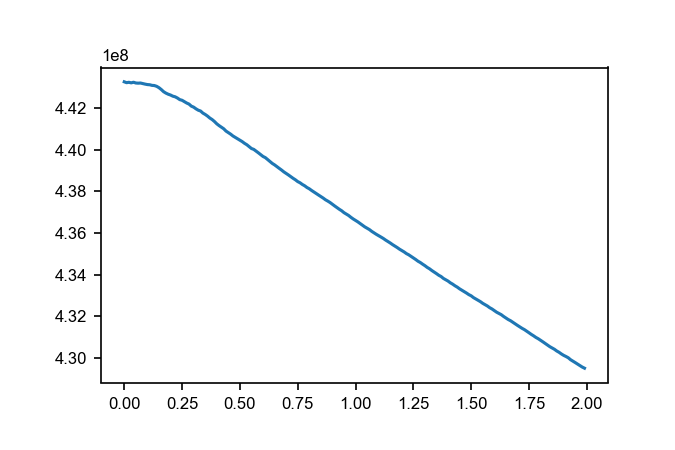

In [15]:
field_w = np.linspace(0,1.990,200) 
freq_w = [443279524.04681301, 443238508.09117198, 443256308.39043826, 443229910.02657849, 443258632.28168947, 443223032.99632245, 443214501.97441512, 443221122.40100372, 443194492.06019419, 443169015.12930155, 443147062.02090454, 443138505.80341417, 443108346.80708325, 443100167.47976613, 443062850.43712831, 442997343.43696225, 442908299.50723827, 442804674.43105781, 442735713.31035155, 442682772.63399386, 442643643.74313676, 442588065.17973536, 442557751.84774125, 442498584.95992595, 442422306.11212313, 442389974.91813684, 442321682.84079999, 442257982.67757368, 442206871.07743037, 442108852.47392827, 442059895.78627068, 441979444.40870166, 441912976.27418953, 441873313.39754242, 441773196.97485524, 441708124.00560629, 441629082.2796725, 441535188.30869883, 441462718.35838127, 441368557.0692544, 441257508.89150512, 441171459.73265195, 441093302.33833456, 441018996.18509376, 440906768.29678565, 440836363.95877421, 440759772.93697476, 440671316.28780913, 440602458.7400046, 440533388.71637285, 440466734.56907332, 440400939.59789211, 440317555.30928844, 440249795.4423753, 440158320.72848958, 440068396.26849747, 440025235.55933237, 439939097.04431355, 439859705.65534794, 439775138.11446071, 439685350.97174513, 439629384.47161442, 439535836.99160808, 439444521.10400808, 439350713.16699487, 439280113.30920076, 439194552.30655992, 439113047.67315406, 439031938.51387542, 438942809.34189939, 438868634.72048104, 438793707.81901079, 438712795.30730736, 438633686.97771615, 438561936.731574, 438475578.78209758, 438418561.26400912, 438337490.9070015, 438274015.69212586, 438190433.10955071, 438129763.13387442, 438048411.0422771, 437973942.50259233, 437904410.36328608, 437827763.29762691, 437757288.56024343, 437682768.59027439, 437600045.09427738, 437536833.90109372, 437466828.95073348, 437380956.04664379, 437300522.95683503, 437221668.48979127, 437141521.93821204, 437071270.96182299, 436979811.98437303, 436909431.06516206, 436844252.25768399, 436754937.38704771, 436675836.65840554, 436608592.43784082, 436535666.00148612, 436455012.48534495, 436372560.47287947, 436295245.36125785, 436232071.03666198, 436165310.86535156, 436079520.71565026, 436005418.38846976, 435935421.01937544, 435872008.424339, 435805302.22378594, 435738424.37273604, 435659829.70381266, 435589692.7232163, 435520010.33643943, 435441400.01929361, 435371668.26875734, 435300683.6433984, 435222681.55621636, 435158154.78045297, 435088998.9018814, 435008779.82113719, 434950450.02773082, 434875342.36778408, 434795733.80489874, 434725207.54334527, 434642336.93468201, 434579458.53493297, 434499953.33860958, 434427390.49127448, 434343260.84323144, 434276725.62073076, 434192540.48320723, 434121254.24866462, 434044491.17573118, 433964823.60923302, 433904352.14807349, 433812629.96238565, 433750997.70469344, 433685464.83162439, 433601540.33123916, 433536913.72861654, 433458806.46018499, 433392809.90566874, 433311316.53560776, 433244134.89938301, 433178317.97407675, 433107320.70647407, 433032309.13900363, 432975637.81011575, 432889429.00803274, 432824574.05926186, 432756272.13637567, 432694529.22445631, 432613811.37038475, 432552562.89732659, 432485894.79053062, 432403670.72100574, 432342341.25212586, 432265695.89132905, 432187066.37324315, 432128894.7861886, 432068429.8039254, 431984224.34064466, 431913104.58378911, 431835848.12980336, 431777839.57421494, 431700844.9018783, 431625889.98206079, 431553340.95212489, 431480746.06599474, 431410435.88900703, 431348991.74524248, 431274763.92294198, 431196773.48109317, 431118136.14777863, 431048775.02297896, 430970995.00966424, 430909126.68723005, 430831961.03131217, 430760193.18025094, 430684497.60644877, 430605152.42180264, 430527248.06308275, 430464933.79810959, 430400892.30144852, 430319066.25511348, 430255951.36235011, 430176450.98886544, 430108317.16891581, 430053105.12247658, 429991355.31230175, 429897489.82234913, 429831704.13892829, 429760199.07269055, 429689029.63917285, 429621304.11864007, 429546973.17583144, 429490966.2569474]
fig, ax = plt.subplots(1,1)
ax.plot(field_w, freq_w)

In [16]:
freq_x = [443204930.69863915,
 443122672.21619278,
 442954365.05046153,
 442708232.16082692,
 442469503.04121089,
 442214872.03077394,
 441978555.74670494,
 441669141.84068984,
 441382757.82237339,
 441090763.71716177,
 440754082.09791738,
 440433133.31001496,
 440114248.01681417,
 439774613.29704124,
 439406269.73391587,
 439097963.87274474,
 438727538.20480251,
 438341985.62241358,
 438002250.75413936,
 437603315.45875603,
 437236063.61343652]

fields = np.linspace(0,0.5,21)

def set_freq_field(field_stp, field_lookup = [], freq_lookup = []):
    idx = np.argmin(field_lookup<field_stp)
    f1 = field_lookup[idx-1]
    f2 = field_lookup[idx]   
    
    if abs(f1-field_stp)<abs(f2-field_stp):
        return freq_field[idx-1]
    else:
        return freq_field[idx]
    
def set_freq_field2(field_stp, field_lookup = [], freq_lookup = []):
    idx = np.argmin(field_lookup<field_stp)
    b1 = field_lookup[idx-1]
    b2 = field_lookup[idx]
    f1 = freq_lookup[idx-1]
    f2 = freq_lookup[idx]
    
    f = f1 + ((field_stp-b1)/(b2-b1))*(f2-f1)
    
    return f

In [ ]:
set_freq_field(0.5, field_lookup = fields, freq_lookup = freq_field)

In [ ]:
idx = np.argmin(fields<0.5)
idx

In [ ]:
freq_field[20]

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(0, 1, 51):
        ami.field(field)
        hetsrc.frequency(set_freq_field(field, field_lookup=fields, freq_lookup=freq_field))
        
        
        for r2 in np.linspace(-1.9e-3, 1.9e-3, 101):
            ivvi_setup.R2_voltage(r2)


            
            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

#### RF Bias vs field

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.265)

ivvi_setup.R2_coarse_voltage(-0.288)


ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(0, 0.2, 11):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))
        
        
        for sd in np.linspace(-1e-3, 1e-3, 101):
            ivvi_setup.SD_voltage(sd)


            
            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.21)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


i = 0
for r2 in np.linspace(0,1.5e-3,4):
    ivvi_setup.R2_voltage(r2)
    i = i+1
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )
        if i%2 == 1:
            for field in np.linspace(0, 1, 51):
                ami.field(field)
                hetsrc.frequency(set_freq_field(field, field_lookup=fields, freq_lookup=freq_field))


                for r2 in np.linspace(-2e-3, 2e-3, 201):
                    ivvi_setup.G_fine_voltage(r2)



                    detector.acquisition() # this gets the data from the alazar
                    datasaver.add_result(*meas.get_result())
        else:
            for field in np.linspace(1, 0, 51):
                ami.field(field)
                hetsrc.frequency(set_freq_field(field, field_lookup=fields, freq_lookup=freq_field))


                for r2 in np.linspace(-2e-3, 2e-3, 201):
                    ivvi_setup.G_fine_voltage(r2)



                    detector.acquisition() # this gets the data from the alazar
                    datasaver.add_result(*meas.get_result())
                

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ami.field,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for field in np.linspace(0, 0.9, 46):
        ami.field(field)
        hetsrc.frequency(set_freq_field(field, field_lookup=fields, freq_lookup=freq_field))
        
        
        for r2 in np.linspace(-1.9e-3, 1.9e-3, 101):
            ivvi_setup.R2_voltage(r2)


            
            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

#### CSD versus field

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.21)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)



exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2

for field in np.linspace(0,0.25,6):
    ami.field(field)
    hetsrc.frequency(set_freq_field(0, field_lookup=fields, freq_lookup=freq_field))
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(0, 1.9e-3, 51):
            ivvi_setup.R2_voltage(r2)

            for pg in np.linspace(0e-3, 2e-3, 101):
                ivvi_setup.G_fine_voltage(pg)

                detector.acquisition() # this gets the data from the alazar
                datasaver.add_result(*meas.get_result())

#### Bias vs field

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.3)
ivvi_setup.T2_voltage(-0.3)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(0)

ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(2, 0, 101):
        ami.field(field)

        for bias in np.linspace(-0.5e-3, 0e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

### RF CSD hard sweep

In [37]:
def trigger_func(do_start):
#     print('calling trigger func with argument', do_start)
    if do_start:
#         print('start AWG')
        station.awg.start()
    else:
#         print('stop AWG')
        station.awg.stop()

In [41]:
setup_awg = True
navgs = 100

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
acq.trigger_func = trigger_func

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e8)
sequence.step_len(400e-6)
sequence.start_voltage(-0.2)
sequence.stop_voltage(0.02)
sequence.voltage_points(100)
# sequence.start_voltage(0.0)
# sequence.stop_voltage(.005)
# sequence.voltage_points(100)
sequence.sweep_wait = 'off'  # why is this not a qcodes parameter :'(
# sequence.setup(start_awg=False)

if setup_awg:
    sequence.setup(program_awg=True, start_awg=False) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

Instrument sequence already exists.
Instrument detector already exists.
frequency 25.0 Hz


In [ ]:
setup_awg = True
navgs = 1000

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
acq.trigger_func = trigger_func

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
sequence.step_len(10e-6)
sequence.start_voltage(0)
sequence.stop_voltage(0.02)
sequence.voltage_points(100)
# sequence.start_voltage(0.0)
# sequence.stop_voltage(.005)
# sequence.voltage_points(100)
sequence.sweep_wait = 'off'  # why is this not a qcodes parameter :'(
# sequence.setup(start_awg=False)

if setup_awg:
    sequence.setup(program_awg=True, start_awg=False) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

#### CSD

In [ ]:
ivvi_setup.T4_voltage(-0.32)

In [42]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.1)
ivvi_setup.T3_voltage(-0.3)
ivvi_setup.T4_voltage(-0.3)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(40)

ivvi_setup.SD_voltage(0e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0,1e-3,51):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

Starting experimental run with id: 722


KeyboardInterrupt: 

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.4)
ivvi_setup.T3_voltage(-0.38)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(-0.08)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_coarse_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.R2_coarse_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2c in np.linspace(-0.07,-0.08,41):
        ivvi_setup.R2_coarse_voltage(r2c)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.4)
ivvi_setup.T3_voltage(-0.38)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

for t3 in np.linspace(-0.5,-0.3,21):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0,0.5e-3,51):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.2475)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.R1_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r1 in np.linspace(0e-3,2e-3,101):
        ivvi_setup.R1_voltage(r1)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.2475)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


for field in np.linspace(0.005,0.030,6):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))


    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3,1e-3,401):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.05,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.2475)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


hetsrc.frequency(set_freq_field2(0.05, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3,1e-3,401):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.2475)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))
for t3 in [-0.21, -0.2, -0.17, -0.405, -0.285]:
    ivvi_setup.T3_voltage(t3)
    for field in np.linspace(0,0.05,2):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )
            
            if field == 0:
                for pg in np.linspace(0e-3,2e-3,401):
                    ivvi_setup.G_fine_voltage(pg)

                    cdata = detector.acquisition() # this gets the data from the alazar
                    datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                    #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                    #                     (detector.sweep_params[0], sequence.voltage_vals()),
                    #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                    #                     ))
            else:
                for pg in np.linspace(0e-3,1e-3,401):
                    ivvi_setup.G_fine_voltage(pg)

                    cdata = detector.acquisition() # this gets the data from the alazar
                    datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                    #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                    #                     (detector.sweep_params[0], sequence.voltage_vals()),
                    #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                    #                     ))            

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.0,90,0])

In [ ]:
setup_awg = True
int_time = 100e-3
buffer_len = 100e-6

# averaging
navgs = 100
#navgs = 100

### End User settings

TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', None],
}

### Setting up instruments

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(100e-6) # quick rep-rate is OK here?
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)

    
# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.seq_len() - 2e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.2475)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 0.9e-3, 201):
        ivvi_setup.R2_voltage(r2)

        for pg in np.linspace(0e-3, 1e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.41)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.G_fine_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 0.9e-3, 201):
        ivvi_setup.R2_voltage(r2)

        for pg in np.linspace(0e-3, 1e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3,10e-3,201):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
setup_awg = True
navgs = 25

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
acq.trigger_func = trigger_func

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
sequence.step_len(400e-6)
sequence.start_voltage(-0.02)
sequence.stop_voltage(0.02)
sequence.voltage_points(200)
# sequence.start_voltage(0.0)
# sequence.stop_voltage(.005)
# sequence.voltage_points(100)
sequence.sweep_wait = 'off'  # why is this not a qcodes parameter :'(
# sequence.setup(start_awg=False)

if setup_awg:
    sequence.setup(program_awg=True, start_awg=False) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

for field in np.linspace(0.01,0.05,5):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))


    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3,4e-3,81):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

for field in np.linspace(0.1,0.5,2):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))


    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3,4e-3,81):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.4)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))

for t3 in np.linspace(-0.45, -0.3, 31):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3,4e-3,51):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)


ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.5)
ivvi_setup.T3_voltage(-0.385)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


# hetsrc.frequency(set_freq_field2(0.05, field_lookup=fields, freq_lookup=freq_field))

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3,10e-3,101):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
setup_awg = True
navgs = 250

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
acq.trigger_func = trigger_func

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
sequence.step_len(400e-6)
sequence.start_voltage(-0.02)
sequence.stop_voltage(0.02)
sequence.voltage_points(200)
# sequence.start_voltage(0.0)
# sequence.stop_voltage(.005)
# sequence.voltage_points(100)
sequence.sweep_wait = 'off'  # why is this not a qcodes parameter :'(
# sequence.setup(start_awg=False)

if setup_awg:
    sequence.setup(program_awg=True, start_awg=False) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.265)

ivvi_setup.R2_coarse_voltage(-0.29)
ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0.5, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    cdata = detector.acquisition() # this gets the data from the alazar
    datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
    #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
    #                     (detector.sweep_params[0], sequence.voltage_vals()),
    #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
    #                     ))

#### bias scan

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.470)
ivvi_setup.T4_voltage(-0.335)

ro_attenuator.attenuation(42)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))
hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.T4_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.T4_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

# for t3 in [-0.44,-0.45,-0.46,-0.47]:
#     ivvi_setup.T3_voltage(t3)
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t4 in np.linspace(-0.37, -0.27, 201):
        ivvi_setup.T4_voltage(t4)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.470)
ivvi_setup.T4_voltage(-0.335)

ro_attenuator.attenuation(42)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))
hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.T4_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.T4_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

# for t3 in [-0.44,-0.45,-0.46,-0.47]:
#     ivvi_setup.T3_voltage(t3)
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t4 in np.linspace(-0.37, -0.17, 201):
        ivvi_setup.T4_voltage(t4)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.470)
ivvi_setup.T4_voltage(-0.335)

ro_attenuator.attenuation(42)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))
hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.SD_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for sd in np.linspace(-.5e-3, .5e-3, 51):
        ivvi_setup.SD_voltage(sd)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.075,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.455)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(42)

ivvi_setup.R1_coarse_voltage(2)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0.075, field_lookup=fields, freq_lookup=freq_field))
# hetsrc.frequency(437603315.45875603)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.SD_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for sd in np.linspace(-.5e-3, .5e-3, 101):
        ivvi_setup.SD_voltage(sd)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.45)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(42)

ivvi_setup.R1_coarse_voltage(2)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))
# hetsrc.frequency(437603315.45875603)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.SD_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for t3 in np.linspace(-0.43,-0.47,9):
    ivvi_setup.T3_voltage(t3)
    for t4 in np.linspace(-0.30,-0.35,11):
        ivvi_setup.T4_voltage(t4)
        
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for sd in np.linspace(-0.75e-3, 0.75e-3, 75):
                ivvi_setup.SD_voltage(sd)

                cdata = detector.acquisition() # this gets the data from the alazar
                datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                #                     (detector.sweep_params[0], sequence.voltage_vals()),
                #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                #                     ))

#### R2 versus T4

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.52)
ivvi_setup.T4_voltage(-0.265)

ivvi_setup.R2_coarse_voltage(-0.288)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))
# hetsrc.frequency(437603315.45875603)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.T4_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.T4_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t4 in np.linspace(-0.27, -0.25, 51):
        ivvi_setup.T4_voltage(t4)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

#### diamonds versus field

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.45)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(42)

ivvi_setup.R1_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

# hetsrc.frequency(set_freq_field2(0.5, field_lookup=fields, freq_lookup=freq_field))
hetsrc.frequency(437603315.45875603)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.SD_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for field in np.linspace(0.0, 0.1, 5):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=field_W, freq_lookup=freq_field))
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for sd in np.linspace(-0.5e-3, 0.5e-3, 101):
            ivvi_setup.SD_voltage(sd)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.45)
ivvi_setup.T4_voltage(-0.315)

ivvi_setup.R1_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

# hetsrc.frequency(set_freq_field2(0.5, field_lookup=fields, freq_lookup=freq_field))
hetsrc.frequency(437603315.45875603)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.SD_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for field in np.linspace(0.1,0.5,2):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for sd in np.linspace(-1e-3, 1e-3, 201):
            ivvi_setup.SD_voltage(sd)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.265)

ivvi_setup.R2_coarse_voltage(-0.288)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

# hetsrc.frequency(set_freq_field2(0.5, field_lookup=fields, freq_lookup=freq_field))
hetsrc.frequency(437603315.45875603)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.SD_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for field in np.linspace(0.5,0,21):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for sd in np.linspace(-1e-3, 1e-3, 51):
            ivvi_setup.SD_voltage(sd)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.36)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for t2 in np.linspace(-0.31, -0.4, 10):
    ivvi_setup.T2_voltage(t2)

    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0, 1e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.36)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for t2 in np.linspace(-0.31, -0.25, 3):
    ivvi_setup.T2_voltage(t2)

    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0, 1e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
#180815 2/2: close T3 further

ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.50)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for t2 in np.linspace(-0.28, -0.34, 7):
    ivvi_setup.T2_voltage(t2)

    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0, 1e-3, 101):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.37)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.G_coarse_voltage(-0.6)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R1_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.R1_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r1 in np.linspace(0e-3, 1e-3, 51):
        ivvi_setup.R1_voltage(r1)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

#### hard sweep CSD vs T3

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.08)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.G_coarse_voltage(-0.6)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for t3 in np.linspace(-0.46,-0.3,17):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3, 1e-3, 51):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
setup_awg = True
navgs = 250

BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0

AWGGateRamp1D.chan_map = {
    1 : ['awg_voltage', 'alz_mrkr', None],
}

acq = avgiq_acq
acq.trigger_func = trigger_func

sequence = create_inst(AWGGateRamp1D, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
sequence.step_len(400e-6)
sequence.start_voltage(-0.02)
sequence.stop_voltage(.02)
sequence.voltage_points(200)
sequence.sweep_wait = 'off'  # why is this not a qcodes parameter :'(
# sequence.setup(start_awg=False)

if setup_awg:
    sequence.setup(program_awg=True, start_awg=False) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

# configure the Alazar detector
detector.avg_buffers(False)
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 1e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=int(navgs), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.35)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 1e-3, 101):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.35)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


for t3 in np.linspace(-0.45, -0.25, 5):
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3, 1e-3, 101):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.33)
ivvi_setup.T3_voltage(-0.35)
ivvi_setup.T4_voltage(-0.34)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


for t4 in np.linspace(-0.26, -0.32, 3):
    ivvi_setup.T4_voltage(t4)

    for t3 in np.linspace(-0.45, -0.25, 5):
        ivvi_setup.T3_voltage(t3)
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for pg in np.linspace(0e-3, 1e-3, 51):
                ivvi_setup.G_fine_voltage(pg)

                cdata = detector.acquisition() # this gets the data from the alazar
                datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                #                     (detector.sweep_params[0], sequence.voltage_vals()),
                #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.33)
ivvi_setup.T3_voltage(-0.35)
ivvi_setup.T4_voltage(-0.34)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


for t4 in np.linspace(-0.26, -0.32, 3):
    ivvi_setup.T4_voltage(t4)

    for t3 in np.linspace(-0.45, -0.25, 5):
        ivvi_setup.T3_voltage(t3)
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for pg in np.linspace(0e-3, 1e-3, 51):
                ivvi_setup.G_fine_voltage(pg)

                cdata = detector.acquisition() # this gets the data from the alazar
                datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                #                     (detector.sweep_params[0], sequence.voltage_vals()),
                #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                #                     ))

#### hard sweep vs field

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.4)
ivvi_setup.T3_voltage(-0.38)
ivvi_setup.T4_voltage(-0.5)
ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(0)


ro_attenuator.attenuation(40)



ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ami.field,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ami.field, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(0, 1, 101):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.4)
ivvi_setup.T3_voltage(-0.37)
ivvi_setup.T4_voltage(-0.5)
ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(0)


ro_attenuator.attenuation(40)



ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ami.field,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ami.field, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 0, 101):
        ami.field(field)
        hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
set_freq_field2(1, field_lookup=field_w, freq_lookup=freq_w)

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.4)
ivvi_setup.T3_voltage(-0.37)
ivvi_setup.T4_voltage(-0.5)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(0)


ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ami.field,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ami.field, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

i = 0
for t3 in [-0.37, -0.38, -0.39, -0.40, -0.36, -0.35]:
    ivvi_setup.T3_voltage(t3)
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )
        if i%2==0:
            for field in np.linspace(0, 1, 101):
                ami.field(field)
                hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))

                cdata = detector.acquisition() # this gets the data from the alazar
                datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                #                     (detector.sweep_params[0], sequence.voltage_vals()),
                #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                #                     ))
        if i%2==1:
            for field in np.linspace(1, 0, 101):
                ami.field(field)
                hetsrc.frequency(set_freq_field2(field, field_lookup=field_w, freq_lookup=freq_w))

                cdata = detector.acquisition() # this gets the data from the alazar
                datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
                #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
                #                     (detector.sweep_params[0], sequence.voltage_vals()),
                #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
                #                     ))
    i += 1

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

#### !

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.5e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.08)
ivvi_setup.T3_voltage(-0.355)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.G_coarse_voltage(-0.6)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for field in np.linspace(0,1,21):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3, 1e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(-1.5e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.08)
ivvi_setup.T3_voltage(-0.36)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.G_coarse_voltage(-0.6)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(443.44e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2

for field in np.linspace(1,0,21):
    ami.field(field)
    hetsrc.frequency(set_freq_field2(field, field_lookup=fields, freq_lookup=freq_field))
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for pg in np.linspace(0e-3, 1e-3, 201):
            ivvi_setup.G_fine_voltage(pg)

            cdata = detector.acquisition() # this gets the data from the alazar
            datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
            #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
            #                     (detector.sweep_params[0], sequence.voltage_vals()),
            #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
            #                     ))

#### CSD HARD SWEEP

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.3)
ivvi_setup.T4_voltage(-0.335)

ro_attenuator.attenuation(35)

ivvi_setup.R1_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

# hetsrc.frequency(442993014.497)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


hetsrc.frequency(set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field))


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3,1e-3,51):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
set_freq_field2(0, field_lookup=fields, freq_lookup=freq_field)

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ami_x._disconnect()

In [ ]:
ami_x._connect()

In [ ]:
qc.instrument.ip.IPInstrument._connect(ami_x)

In [ ]:
ami_x._timeout

In [ ]:
ami_x._address

In [ ]:
ami_x._port

In [ ]:
ami_x._socket

In [ ]:
ami_x.field()

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.35)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field(0.8, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 1e-3, 51):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.31)
ivvi_setup.T3_voltage(-0.35)
ivvi_setup.T4_voltage(-0.33)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field(0.8, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ])

delta = Parameter('delta')
meas.register_parameter(delta, setpoints=[ivvi_setup.G_fine_voltage, detector.sweep_params[0], detector.sweep_params[1]])
# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 1e-3, 51):
        ivvi_setup.G_fine_voltage(pg)

        cdata = detector.acquisition() # this gets the data from the alazar
        datasaver.add_result((delta, np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi).repeat(2)), *meas.get_result())
        #datasaver.add_result((ivvi_setup.G_fine_voltage, pg), 
        #                     (detector.sweep_params[0], sequence.voltage_vals()),
        #                     (delta,  np.mod(np.angle(cdata[:,1])-np.angle(cdata[:,0]),2*np.pi))
        #                     ))

In [ ]:
def measure(ns):
    return [ns[setpoints], do_measurement()]
ns[setpoiunts] = figure_out_setpoints()
for sweep
    for sweep
        measure

## gate versus gate maps

### T3 vs T4

In [71]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.R1_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(0)

In [73]:
ivvi_setup.R1_coarse_voltage(2)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.3)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.G_coarse_voltage(-0.5)

ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.T4_voltage,
                          ivvi_setup.T3_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t4 in np.linspace(-0.25, -0.5, 51):
        ivvi_setup.T4_voltage(t4)

        for t3 in np.linspace(-0.3, -0.55, 25):
            ivvi_setup.T3_voltage(t3)

            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 780


### T1 vs T2

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(-0.2)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(-0.2)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.T1_voltage,
                          ivvi_setup.T4_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t4 in np.linspace(-0.3, -0.35, 25):
        ivvi_setup.T4_voltage(t4)

        for t1 in np.linspace(-0.22, -0.32, 51):
            ivvi_setup.T1_voltage(t1)

            datasaver.add_result(*meas.get_result())

### T2 vs T3

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(0)

ivvi_setup.G_coarse_voltage(-0.3)

ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.T3_voltage,
                          ivvi_setup.T2_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for t3 in np.linspace(-0.4, -0.5, 25):
        ivvi_setup.T3_voltage(t3)

        for t2 in np.linspace(-0.18, -0.28, 51):
            ivvi_setup.T2_voltage(t2)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(0)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

exp = select_experiment('DC_CSD', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_coarse_voltage,
                          ivvi_setup.T2_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for gc in np.linspace(-1, 0, 11):
        ivvi_setup.G_coarse_voltage(gc)

        for t2 in np.linspace(0.3, -0.3, 151):
            ivvi_setup.T2_voltage(t2)

            datasaver.add_result(*meas.get_result())

## Pinchoff

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(0)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.R1_coarse_voltage(0)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.T3_voltage,
                      ],
                      soft_data_params=[
#                           ivvi_setup.SD_conductance,
#                           lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for rc in np.linspace(-0.5, 0, 201):
        ivvi_setup.T3_voltage(rc)
        datasaver.add_result(*meas.get_result())

## Diamond scans

### DC scans

In [ ]:
ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(0)
ivvi_setup.T4_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.53)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R1_coarse_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r1 in np.linspace(2, 1.9, 21):
        ivvi_setup.R1_coarse_voltage(r1)
        datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.40)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.G_coarse_voltage(0e-3)

ivvi_setup.SD_voltage(30e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0e-3, 1e-3, 201):
        ivvi_setup.R2_voltage(r2)
        datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.465)
ivvi_setup.T4_voltage(0)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(30e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()



exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 0.5e-3, 401):
        ivvi_setup.G_fine_voltage(pg)
        datasaver.add_result(*meas.get_result())

#### vs R2

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.43)
ivvi_setup.T4_voltage(-0.27)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.405)
ivvi_setup.R2_coarse_voltage(0)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0, 1e-3, 21):
        ivvi_setup.R2_voltage(r2)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 51):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

### dsgfsg


In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.295)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for bias in np.linspace(-0.5e-3, 0.5e-3, 101):
        ivvi_setup.SD_voltage(bias)

        datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.295)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_coarse_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for gc in np.linspace(-0.4,-0.5, 101):
        ivvi_setup.G_coarse_voltage(gc)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.295)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_coarse_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for gc in np.linspace(-0.4,-0.5, 51):
        ivvi_setup.G_coarse_voltage(gc)

        for bias in np.linspace(-10e-3, 10e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.34)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_coarse_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for gc in np.linspace(-0.4,-0.5, 51):
        ivvi_setup.G_coarse_voltage(gc)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.33)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_coarse_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for gc in np.linspace(0,-0.5, 251):
        ivvi_setup.G_coarse_voltage(gc)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.285)
ivvi_setup.T3_voltage(-0.43)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0, 2e-3, 151):
        ivvi_setup.G_fine_voltage(pg)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 51):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.285)
ivvi_setup.T3_voltage(-0.43)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(30e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0, 2e-3, 201):
        ivvi_setup.G_fine_voltage(pg)

        datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.445)
ivvi_setup.T4_voltage(-0.32)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 1e-3, 41):
        ivvi_setup.R2_voltage(r2)

        for bias in np.linspace(-0.6e-3, 0.6e-3, 51):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.3)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.5)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 1.5, 21):
        ami.field(field)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.34)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()


exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1

i = 0
for gc in np.linspace(-0.45,-0.5,6):
    ivvi_setup.G_coarse_voltage(gc)
    i += 1
    if (i%2 == 1):
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for field in np.linspace(0,1, 41):
                ami.field(field)

                for bias in np.linspace(-0.4e-3, 0.4e-3, 81):
                    ivvi_setup.SD_voltage(bias)

                    datasaver.add_result(*meas.get_result())
    else:
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for field in np.linspace(1,0, 41):
                ami.field(field)

                for bias in np.linspace(-0.4e-3, 0.4e-3, 81):
                    ivvi_setup.SD_voltage(bias)

                    datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.515)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 0, 201):
        ami.field(field)

        for bias in np.linspace(-0.4e-3, 0.4e-3, 201):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.53)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.405)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 0, 25):
        ami.field(field)

        for bias in np.linspace(-0.4e-3, 0.4e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.53)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.41)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(0, 1, 101):
        ami.field(field)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 201):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.53)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.415)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 0, 101):
        ami.field(field)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 201):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.53)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.42)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(0, 1, 101):
        ami.field(field)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 201):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.53)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.425)
ivvi_setup.R2_coarse_voltage(2)
ivvi_setup.R1_coarse_voltage(2)

ro_attenuator.attenuation(42)


ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 0, 101):
        ami.field(field)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 201):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.24)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.40)
ivvi_setup.R2_coarse_voltage(2)

ro_attenuator.attenuation(42)

# ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_coarse_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for gc in np.linspace(-0.4, -0.45, 51):
        ivvi_setup.G_coarse_voltage(gc)

        for bias in np.linspace(-0.2e-3, 0.2e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(-0.2475)
ivvi_setup.T3_voltage(2)
ivvi_setup.T4_voltage(2)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(-0.4)
ivvi_setup.R2_coarse_voltage(2)

ro_attenuator.attenuation(42)

# ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(1e-3)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(0.4, 0.8, 41):
        ami.field(field)

        for bias in np.linspace(-0.5e-3, 0.5e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0.85e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.465)
ivvi_setup.T4_voltage(-0.335)

ivvi_setup.G_coarse_voltage(0.3e-3)

ivvi_setup.SD_voltage(30e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 0, 101):
        ami.field(field)

        for bias in np.linspace(-1e-3, 1e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0.4e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.465)
ivvi_setup.T4_voltage(-0.335)

ivvi_setup.G_coarse_voltage(0.3e-3)

ivvi_setup.SD_voltage(30e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(0, 1, 101):
        ami.field(field)

        for bias in np.linspace(-1e-3, 1e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0.85e-3)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.465)
ivvi_setup.T4_voltage(-0.335)

ivvi_setup.G_coarse_voltage(0.3e-3)

ivvi_setup.SD_voltage(30e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(11.1)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ami.field,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(1, 0, 101):
        ami.field(field)

        for bias in np.linspace(-1e-3, 1e-3, 101):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(-0.465)
ivvi_setup.T4_voltage(0)

ro_attenuator.attenuation(40)

ivvi_setup.G_coarse_voltage(0)
ivvi_setup.G_fine_voltage(0)

ivvi_setup.SD_voltage(0e-6)
ivvi_setup.SD_lockin_voltage(10e-6)
lockin1.frequency(16.2)

hetsrc.frequency(443094846.067)

hetsrc.RF.off()
hetsrc.LO.off()

exp = select_experiment('DC_Diamonds', SAMPLE)

meas = MeasurementExt(station, exp=exp,
                      soft_sweep_params=[
                          ivvi_setup.G_fine_voltage,
                          ivvi_setup.SD_voltage,
                      ],
                      soft_data_params=[
                          ivvi_setup.SD_conductance,
                          lockin1.X,
                          ivvi_setup.SD_current,
                      ])

meas.write_period = 1
    
with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 2e-3, 401):
        ivvi_setup.G_fine_voltage(pg)

        for bias in np.linspace(-1e-3, 1e-3, 201):
            ivvi_setup.SD_voltage(bias)

            datasaver.add_result(*meas.get_result())

### RF scans

#### vs R2

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,90,0])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.47)
ivvi_setup.T4_voltage(-0.335)

ro_attenuator.attenuation(42)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field2(0.1, field_lookup=fields, freq_lookup=freq_field))
# hetsrc.frequency(443094846.067)

exp = select_experiment('RF_Diamond', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          ivvi_setup.R2_voltage,
                          ivvi_setup.SD_voltage,
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 1e-3, 101):
        ivvi_setup.R2_voltage(r2)

        for bias in np.linspace(-0.6e-3, 0.6e-3, 101):
            ivvi_setup.SD_voltage(bias)
            
            detector.acquisition() # this gets the data from the alazar

            datasaver.add_result(*meas.get_result())

## Freq scans

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(2)
ivvi_setup.T2_voltage(2)
ivvi_setup.T3_voltage(-0.450)
ivvi_setup.T4_voltage(-0.315)

ro_attenuator.attenuation(42)

ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          hetsrc.frequency,
                          ivvi_setup.R2_voltage
                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-0.7e-3, -0.95e-3, 31):
        ivvi_setup.R2_voltage(r2)

        for freq in np.linspace(436e6, 450e6, 201):
            hetsrc.frequency(freq)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
# ivvi_setup.R1_voltage(0)
# ivvi_setup.R2_voltage(0)
# ivvi_setup.P1_voltage(0)
# ivvi_setup.P2_voltage(0)

# ivvi_setup.T1_voltage(0)
# ivvi_setup.T2_voltage(-0.25)
# ivvi_setup.T3_voltage(-0.2)
# ivvi_setup.T4_voltage(-0.335)

# ro_attenuator.attenuation(35)

# ivvi_setup.G_coarse_voltage(0)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.RF.on()
hetsrc.LO.on()
# hetsrc.frequency(443.3e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          hetsrc.frequency,

                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )


    for freq in np.linspace(430e6, 450e6, 201):
        hetsrc.frequency(freq)

        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(0)
ivvi_setup.T3_voltage(-0.46)
ivvi_setup.T4_voltage(-0.265)

ivvi_setup.R2_coarse_voltage(-0.29)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

# hetsrc.frequency(443.3e6)

exp = select_experiment('RF_CSD', SAMPLE)


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          hetsrc.frequency,
                          ami.field

                      ])


# the measurement loop
meas.write_period = 2


with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for field in np.linspace(0, 2, 201):
        ami.field(field)
        for freq in np.linspace(420e6, 450e6, 301):
            hetsrc.frequency(freq)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
enumerate(np.linspace(0,10,2))

# PySweep

In [ ]:
import importlib

In [ ]:
importlib.reload(pytopo.sweep.param_table)

In [ ]:
import pytopo.sweep.decorators

In [ ]:
pytopo.sweep.decorators

In [ ]:
ivvi_setup.R1_voltage(0)
ivvi_setup.R2_voltage(0)
ivvi_setup.P1_voltage(0)
ivvi_setup.P2_voltage(0)

ivvi_setup.T1_voltage(0)
ivvi_setup.T2_voltage(-0.25)
ivvi_setup.T3_voltage(0.5)
ivvi_setup.T4_voltage(-0.25)

ivvi_setup.SD_voltage(0e-6)
lockin1.amplitude(0.004)
lockin1.frequency(16.2)

hetsrc.frequency(set_freq_field(0, field_lookup=fields, freq_lookup=freq_field))

exp = select_experiment('RF_CSD', SAMPLE)

@pytopo.sweep.decorators.getter(('I1', 'V'), ('Q1', 'V'), ('I2', 'V'), ('Q2', 'V'))
def measurement_function():
    r = detector.acquisition()[0]
    return [np.real(r[0]), np.imag(r[0]), np.real(r[1]), np.imag(r[1])]

#measurement_function.measurable = True
#measurement_function.parameter_table = 
sweep_object = pytopo.sweep.base.Nest(
    pytopo.sweep.convenience.sweep(ivvi_setup.R2_voltage, lambda: np.linspace(0e-3, 1.9e-3, 21)),
    call(sleep, 1)
    pytopo.sweep.convenience.sweep(ivvi_setup.G_fine_voltage, lambda: np.linspace(1e-3, 2e-3, 21)), 
    pytopo.sweep.base.Measure(measurement_function)
)

meas = pytopo.sweep.measurement.SweepMeasurement()
meas.register_sweep(sweep_object)

with meas.run() as datasaver:
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for data in sweep_object: 
        datasaver.add_result(*data.items())
    

In [ ]:
sweep_object.parameter_table.nests

In [ ]:
test=  pytopo.sweep.base.IteratorSweep(*measurement_function(), measurable=True)

In [ ]:
test._iterator_function()

In [ ]:
test._parameter_table

In [ ]:
for data in test:
    print(data)

In [ ]:
measurement_function.getter_setter_decorated

In [ ]:
pytopo.sweep.convenience.sweep(ivvi_setup.G_fine_voltage, lambda: np.linspace(1e-3, 2e-3, 21))

In [ ]:
measurement_function()[0]()

In [ ]:
measurement_function.measurable

In [ ]:
bla

In [ ]:
r = detector.acquisition()[0]

In [ ]:
detector.acquisition()

In [ ]:
r